## Loan Default Prediction System 

### Imports and Loading 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
df = pd.read_csv("loan_default.csv")

- loan defaulted = 1
- not defaulted = 0 

### EDA

In [3]:
df.sample(5)

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
90778,YEKBDHQFGC,69,17984,125938,551,71,2,10.31,12,0.66,Bachelor's,Self-employed,Married,No,Yes,Home,Yes,0
247152,BOSGF6RWS0,54,34880,157716,333,86,2,24.83,36,0.48,High School,Part-time,Single,No,No,Auto,Yes,0
178861,PMLYPA4Y6Y,54,55129,212065,320,97,2,9.81,48,0.58,PhD,Part-time,Married,No,Yes,Education,No,0
226606,IRIDE2G4ER,18,39880,190470,703,42,3,20.34,48,0.66,Bachelor's,Unemployed,Divorced,Yes,No,Business,Yes,0
51048,YJGY5LJQQD,62,66427,157839,732,115,2,7.26,24,0.81,Bachelor's,Full-time,Single,No,No,Other,Yes,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [5]:
df.isnull().sum()
# no null value  in any column 

LoanID            0
Age               0
Income            0
LoanAmount        0
CreditScore       0
MonthsEmployed    0
NumCreditLines    0
InterestRate      0
LoanTerm          0
DTIRatio          0
Education         0
EmploymentType    0
MaritalStatus     0
HasMortgage       0
HasDependents     0
LoanPurpose       0
HasCoSigner       0
Default           0
dtype: int64

In [6]:
df.shape

(255347, 18)

In [7]:
numeric_df = df.select_dtypes(include=['number'])
numeric_df.head()


,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
0,56,85994,50587,520,80,4,15.23,36,0.44,0
1,69,50432,124440,458,15,1,4.81,60,0.68,0
2,46,84208,129188,451,26,3,21.17,24,0.31,1
3,32,31713,44799,743,0,3,7.07,24,0.23,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0


Correlation coefficient can only find linear relationship between variables like increases, decreases or not there. It can't find quadratic or other types of relationship. So a correlation heatmap **doesn't proof that there doesn't exist any correlation between the variables**

In [8]:
# Now we only need how these variables correlate with default so choose that
corrs = numeric_df.corr()['Default']
print(corrs.sort_values)

<bound method Series.sort_values of Age              -0.167783
Income           -0.099119
LoanAmount        0.086659
CreditScore      -0.034166
MonthsEmployed   -0.097374
NumCreditLines    0.028330
InterestRate      0.131273
LoanTerm          0.000545
DTIRatio          0.019236
Default           1.000000
Name: Default, dtype: float64>


now before we proceed with anything, let's check if the class is biased towards default or non default

In [9]:
df['Default'].value_counts()
# the number of defaulters are 7.6 times lesser  
# this causes class imbalance which will lead to poor performance on minority classes 
# meaning model can't successfully predict those who will actually pay the loan
# accuracy will be misleading - use recall, f1, etc 

Default
0    225694
1     29653
Name: count, dtype: int64

### One Hot Encoding

- use one hot encoding for nominal categorical variables (no intrinsic order)
- it avoids inducing artificial order 
- label encoding is useful when the order matters like education level or satisfaction ratings

In [10]:
to_dummy = ['Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner']

df = pd.get_dummies(data=df, columns=to_dummy, drop_first=True)

### Train Test Split & Scaling

In [11]:
# first split the training and testing data 
train_df, test_df = train_test_split(
    df,
    test_size=0.2, 
    random_state=42, 
    stratify=df['Default'] # preserves class distribution in train and test sets
)

what stratify does?
- preserves class balance in both training and testing sets
- eg. if the original dataset has 83% good and 17% defaulters then 
- training set will have 83% good and 17% defaulters
- testing set will also have the same
- this ensures that the ratio is maintained in both training and testing sets
- because random splits might cause most of the defaulters go to training 
- and almost no defaulters enter test so our evaluation will be skewed 

P.S. stratify doesn't balance the class

things we can do to fix class imbalance:
- undersampling of majority 
- oversampling of minority 
- higher penalty for getting the minority wrong  

- we ditched loan id since it might cause problem with model training 
- load id is totally random and is an identifier and has no relation with default
- it is an identifier, not a feature

In [12]:
train_x = train_df.drop(columns=['LoanID', 'Default'])
train_y = train_df['Default']

test_x = test_df.drop(columns=['LoanID', 'Default'])
test_y = test_df['Default']

#### Scaling

In [13]:
# scale since ranges vary 

# but first choose numerical columns
num_cols = train_x.select_dtypes(include=['int64','float64']).columns

# fit scaler on train only 
scaler = StandardScaler()

# change the numerical columns to standard scaler
train_x[num_cols] = scaler.fit_transform(train_x[num_cols])

# apply the same transformation to the test set (it standardizes according to what is learnt from the training)
test_x[num_cols] = scaler.transform(test_x[num_cols])

### Training

Using Decison Tree and Random Forest Classifier initially to make predictions. 

In [14]:
def train_rf(X_train, y_train):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

def train_dt(X_train, y_train):
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model

In [15]:
dt = train_dt(train_x, train_y)
y_pred_dt = dt.predict(test_x)

In [16]:
rf = train_rf(train_x, train_y)
y_pred_rf = rf.predict(test_x)

### Evaluation 

In [17]:
def evaluate(model, test_y, y_pred):
    print(f"Model: {model}")
    print("Accuracy:", accuracy_score(test_y, y_pred))
    print("Classification Report:\n", classification_report(test_y, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred))

In [18]:
evaluate("Decision Tree", test_y, y_pred_dt)
print()
evaluate("Random Forest", test_y, y_pred_rf)

Model: Decision Tree
Accuracy: 0.8014098296455845
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     45139
           1       0.20      0.23      0.21      5931

    accuracy                           0.80     51070
   macro avg       0.55      0.55      0.55     51070
weighted avg       0.82      0.80      0.81     51070

Confusion Matrix:
 [[39572  5567]
 [ 4575  1356]]

Model: Random Forest
Accuracy: 0.8853534364597612
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.64      0.03      0.06      5931

    accuracy                           0.89     51070
   macro avg       0.76      0.51      0.50     51070
weighted avg       0.86      0.89      0.84     51070

Confusion Matrix:
 [[45040    99]
 [ 5756   175]]


#### Report

- accuracy  is misleading since the class is imbalanced 
- ppl who actually pay the loan are 7.5 times more than ppl who don't pay the loan (like you'd expect in reality)
- ppl paying the loan are 88% and non paying are 12%
- so even if the model predicted 0 out of 100 times, you would still get 88% accuracy which is misleading 

1. Decision tree
- Precision (1) = 0.20 → Only 20% of predicted defaulters were actually defaulters.
- Recall (1) = 0.23 → It found only 23% of all actual defaulters.

2. Random Forest 
- Precision (1) = 0.64 → Better at being “right” when it predicts a default.
- Recall (1) = 0.03 → Only 3% of actual defaulters were detected.
Random forest is being conservative, it is afraid to predict 1 (defaulters) since class 1 is rare 

To fix this:

1. Use class weights. e.g. RandomForestClassifier(class_weight='balanced', random_state=42). Tells model to penalize mistakes on defaulters more heavily. 

2. Try oversamplimg minority (SMOTE) or random undersampling of majority class

3. Try other models like XGBoost and LightGBM since they have in-built imbalance handling 

Over series of experiments, I figured out that XGBoost works best with threhsold tuning on a custom cost based evaluation matrix to minimize loss.  

### Solution3 (XGBoost)

In [19]:
from xgboost import XGBClassifier

# Ratio = non-defaulters / defaulters
scale_pos_weight = len(train_y[train_y == 0]) / len(train_y[train_y == 1])

model = XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss')
model.fit(train_x, train_y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
from sklearn.metrics import precision_recall_curve, auc

probs = model.predict_proba(test_x)[:, 1]
precision, recall, _ = precision_recall_curve(test_y, probs)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)


PR AUC: 0.31032047389165496


In [21]:
y_pred = (model.predict_proba(test_x)[:,1] > 0.5).astype(int)

In [22]:
# tune decision threshold, rn default is 0.5 
for thresh in [0.5, 0.4, 0.3, 0.2]:
    y_pred = (probs > thresh).astype(int)
    print(f"Threshold: {thresh}")
    print(classification_report(test_y, y_pred))

# recall(1) go up and precision(1) go down as threshold decreases 

Threshold: 0.5
              precision    recall  f1-score   support

           0       0.94      0.73      0.82     45139
           1       0.23      0.63      0.34      5931

    accuracy                           0.71     51070
   macro avg       0.58      0.68      0.58     51070
weighted avg       0.85      0.71      0.76     51070

Threshold: 0.4
              precision    recall  f1-score   support

           0       0.95      0.60      0.73     45139
           1       0.20      0.75      0.31      5931

    accuracy                           0.61     51070
   macro avg       0.57      0.67      0.52     51070
weighted avg       0.86      0.61      0.68     51070

Threshold: 0.3
              precision    recall  f1-score   support

           0       0.96      0.44      0.60     45139
           1       0.17      0.85      0.28      5931

    accuracy                           0.49     51070
   macro avg       0.56      0.65      0.44     51070
weighted avg       0.87      

Highest Recall of 93% achieved but at a heavy cost of 14% precision. 

Catches 93% of defauulters but wrongly predicts 86% of clients as defaulters.

The threshold to be chosen highly depends on how much a company loses on a FP and a FN.

Below is mine custom cost based evaluation matrix to choose the most optimum threshold for minimizing loss. 

### Optimization

general statement: lowering the threshold increases the recall but at the cost of precision. 

- recall: out of all the actual defaulters, how many actually do we catch? (TP / TP + FN)
- precision: out of all the predicted defaulters, how many actually were defaulters? (TP / TP + FP)

using xgboost, at the threshold of 0.2, for the case of 1 (defaulters):
- we get 93% recall, meaning out of all the actual defaulters, we can catch the 93% of them. it is good

- but a very low precision of 14%, which means that out of everyone we predict as defaulters, only 14% of them prove to be actual defaulters
- meaning 86% of people whom we predicted as defaulters were actually innocent
- this means that you will lose revenue on those 86% of people who might actually pay back the loan

the current state of our system is such that:
+ we are very good at predicting people who will not pay the loan 
- but very bad at identifying those who will actually pay back causing anger among public and loss of potential good clients

so now we must evaluate the actual cost:

think:
catching defaulters matters most or losing people who will actually pay back the loan?

truth is that both matter a lot to the bank so we must make a cost based evaluation matrix and see where we can get the lowest loss.


Assumptions for the Cost Matrix:
| Outcome                                               | Cost          |
| ----------------------------------------------------- | ------------- |
| True Positive (TP) – caught a defaulter               | **+0**        |
| False Positive (FP) – wrongly flagged as defaulter    | **–₹50,000**   |
| False Negative (FN) – missed a real defaulter         | **–₹500,000** |
| True Negative (TN) – correctly passed a good borrower | **+0**        |


In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def evaluate_thresholds(y_true, y_probs, thresholds=np.arange(0.1, 0.91, 0.05),
                        cost_fp=50000, cost_fn=500000):
    costs = []
    recalls = []
    precisions = []
    
    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        total_cost = (fp * cost_fp) + (fn * cost_fn)
        recall_1 = tp / (tp + fn + 1e-8)
        precision_1 = tp / (tp + fp + 1e-8)
        
        costs.append(total_cost)
        recalls.append(recall_1)
        precisions.append(precision_1)

        print(f"Threshold: {thresh:.2f} | Cost: ₹{total_cost:,} | Recall(1): {recall_1:.2%} | Precision(1): {precision_1:.2%}")

    # Plot
    fig, ax1 = plt.subplots(figsize=(12, 6))

    color = 'tab:red'
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Total Cost (₹)', color=color)
    ax1.plot(thresholds, costs, marker='o', color=color, label='Total Cost (₹)')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.plot(thresholds, recalls, marker='s', color=color, label='Recall (1)')
    ax2.plot(thresholds, precisions, marker='^', color='tab:blue', label='Precision (1)')
    ax2.set_ylabel('Precision / Recall', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title('Cost & Metrics Across Thresholds (with 50K FP and 500k FN cost)')
    fig.tight_layout()
    plt.grid(True)
    plt.savefig("cost_preicison_recall.png", dpi=300, bbox_inches='tight')
    plt.show()

    return thresholds, costs, recalls, precisions



Threshold: 0.10 | Cost: ₹2,082,400,000 | Recall(1): 98.52% | Precision(1): 12.54%
Threshold: 0.15 | Cost: ₹1,963,050,000 | Recall(1): 96.32% | Precision(1): 13.35%
Threshold: 0.20 | Cost: ₹1,865,550,000 | Recall(1): 93.07% | Precision(1): 14.26%
Threshold: 0.25 | Cost: ₹1,776,000,000 | Recall(1): 89.43% | Precision(1): 15.35%
Threshold: 0.30 | Cost: ₹1,703,050,000 | Recall(1): 85.20% | Precision(1): 16.66%
Threshold: 0.35 | Cost: ₹1,664,100,000 | Recall(1): 80.42% | Precision(1): 18.04%
Threshold: 0.40 | Cost: ₹1,653,050,000 | Recall(1): 75.05% | Precision(1): 19.60%
Threshold: 0.45 | Cost: ₹1,673,500,000 | Recall(1): 69.13% | Precision(1): 21.29%
Threshold: 0.50 | Cost: ₹1,725,550,000 | Recall(1): 62.70% | Precision(1): 23.09%
Threshold: 0.55 | Cost: ₹1,792,450,000 | Recall(1): 56.10% | Precision(1): 25.33%
Threshold: 0.60 | Cost: ₹1,883,900,000 | Recall(1): 49.15% | Precision(1): 27.94%
Threshold: 0.65 | Cost: ₹2,009,200,000 | Recall(1): 41.56% | Precision(1): 30.85%
Threshold: 0.70 

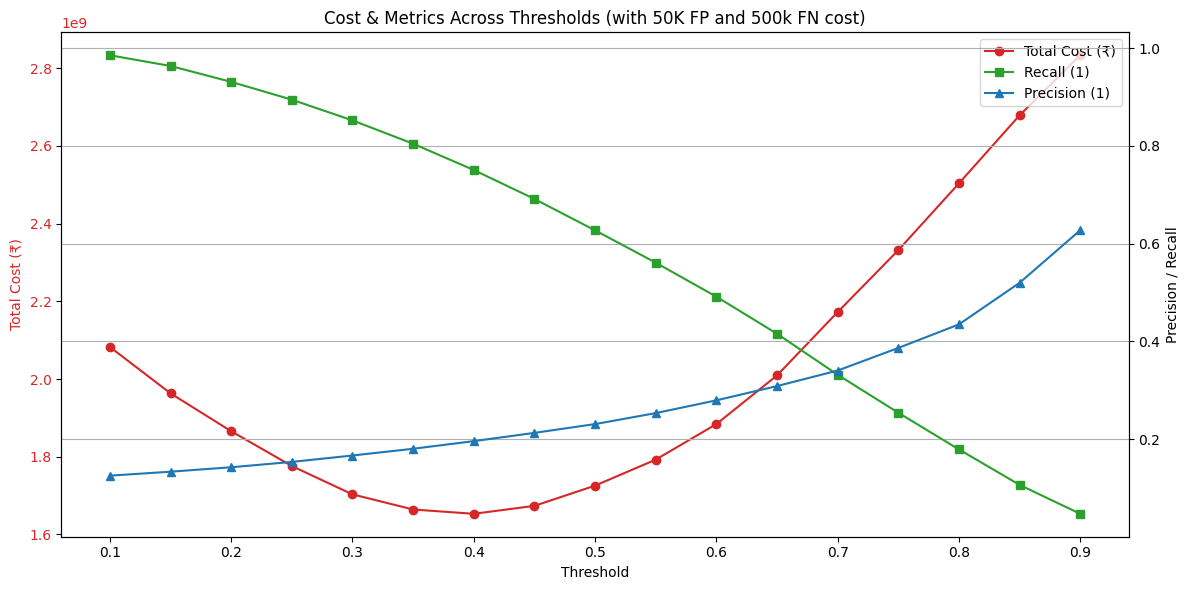

(array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
        0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 [np.int64(2082400000),
  np.int64(1963050000),
  np.int64(1865550000),
  np.int64(1776000000),
  np.int64(1703050000),
  np.int64(1664100000),
  np.int64(1653050000),
  np.int64(1673500000),
  np.int64(1725550000),
  np.int64(1792450000),
  np.int64(1883900000),
  np.int64(2009200000),
  np.int64(2172200000),
  np.int64(2331600000),
  np.int64(2503550000),
  np.int64(2678700000),
  np.int64(2833350000)],
 [np.float64(0.9851627044326671),
  np.float64(0.9632439723470524),
  np.float64(0.930703085481486),
  np.float64(0.89428426909308),
  np.float64(0.8519642556047008),
  np.float64(0.8042488619106318),
  np.float64(0.750463665485162),
  np.float64(0.6912830888540022),
  np.float64(0.6270443432800084),
  np.float64(0.5609509357603086),
  np.float64(0.49148541561205283),
  np.float64(0.41561288146954034),
  np.float64(0.33181588264992107),
  np.float64(0.254088686561702

In [24]:
# After training XGBoost model:
y_probs = model.predict_proba(test_x)[:, 1]  # Probabilities for class 1 (defaulter)
evaluate_thresholds(test_y, y_probs)

In [39]:
# save the model to avoid retraining

import joblib

final_threshold = 0.40

# Bundle everything together (optional)
joblib.dump({
    "model": model,
    "threshold": final_threshold,
    "features": train_x.columns.tolist()
}, "xgb_final_model_thresh045.pkl")

['xgb_final_model_thresh045.pkl']

### Graphical Insight

As one can see in the above graph, the red line (the cost function) dips the lowest at the threshold of 0.40, we choose our model to operate at 0.40 threshold with the recall of 75% and precision of 20% (see from graph)

- it has the lowest loss of 1.6B rupees 
- we can catch 75% of the defaulters 
- we have 20% precision  
- it totally depends on how much a bank loses on missing a defaulter and how much it loses on losing a person who might pay back the loan
- we have taken the assumption that defaulters usually take the loan between rupees 3-10 lacs so with loss of principal, interest and npa (non performing asset) burden, reasonable loss estimate to be 5 lacs 
- and about false positive (not a defaulter, predicted defaulter) a.k.a. a lost good customer, they may go to other bank so you lose interest on them, loss of customer acquisition and onboarding costs, they may never take your credit cards, insurance, etc and also harm reputation by bad mouthing so losing a good customer may come around at the cost of 50k (varies by bank) 

### Sample loading of the Model

In [30]:
check = joblib.load("xgb_final_model_thresh045.pkl")

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

threshold = check["threshold"]
test_x = test_x[check["features"]]

# check is a dictionary that contains model, threhsold and features so check['model'] is our trained model
probs = check["model"].predict_proba(test_x)[:, 1]
y_pred = (probs>threshold).astype(int)

# calculate PR
precision, recall, _ = precision_recall_curve(test_y, probs)
pr_auc = auc(recall, precision)
print("PR AUC:", pr_auc)

PR AUC: 0.31032047389165496


In [ ]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.60      0.73     45139
           1       0.20      0.75      0.31      5931

    accuracy                           0.61     51070
   macro avg       0.57      0.67      0.52     51070
weighted avg       0.86      0.61      0.68     51070



### K-Fold Cross Validation

In [35]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, classification_report
import numpy as np
import xgboost as xgb

X = df.drop(columns=['Default'])
y = df['Default']

X = X[check["features"]]  # ensure same order

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

recalls, precisions, pr_aucs, costs = [], [], [], []

for train_idx, test_idx in kfold.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model.fit(X_train_fold, y_train_fold)

    probs = model.predict_proba(X_test_fold)[:, 1]
    y_pred = (probs > 0.45).astype(int)

    precision, recall, _ = precision_recall_curve(y_test_fold, probs)
    pr_auc = auc(recall, precision)

    pr_report = classification_report(y_test_fold, y_pred, output_dict=True)
    rec_1 = pr_report['1']['recall']
    prec_1 = pr_report['1']['precision']

    tn, fp, fn, tp = confusion_matrix(y_test_fold, y_pred).ravel()
    total_cost = fp * 50000 + fn * 500000

    recalls.append(rec_1)
    precisions.append(prec_1)
    pr_aucs.append(pr_auc)
    costs.append(total_cost)

print(f"Avg Recall(1): {np.mean(recalls):.2%}")
print(f"Avg Precision(1): {np.mean(precisions):.2%}")
print(f"Avg PR AUC: {np.mean(pr_aucs):.2%}")
print(f"Avg Cost: ₹{int(np.mean(costs)):,}")

Avg Recall(1): 10.81%
Avg Precision(1): 48.81%
Avg PR AUC: 30.17%
Avg Cost: ₹2,678,350,000


My original cost evaluation was based on one specific train/test split,  possibly a lucky split where defaulters were better clustered or cleaner to catch.

Now, with 5-fold CV, I'm averaging across different distributions, and that shows the true stability of the model.

Right now, I was applying 0.40 blindly on all folds, but optimal threshold might vary fold-to-fold.

→ This approach gives each fold its own best threshold using cost minimization.

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
import numpy as np
import xgboost as xgb

X = df.drop(columns=['Default'])
y = df['Default']
X = X[check["features"]]  # Ensure column order matches training

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

recalls, precisions, pr_aucs, costs, best_thresholds = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
    model.fit(X_train, y_train)
    probs = model.predict_proba(X_test)[:, 1]

    # Tune best threshold per fold
    thresholds = np.arange(0.1, 0.91, 0.05)
    min_cost = float('inf')
    best_thresh = 0.5
    best_pred = None

    for t in thresholds:
        y_pred = (probs > t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost = fp * 50000 + fn * 500000
        if cost < min_cost:
            min_cost = cost
            best_thresh = t
            best_pred = y_pred

    # Final metrics at best threshold
    pr_report = classification_report(y_test, best_pred, output_dict=True)
    rec_1 = pr_report['1']['recall']
    prec_1 = pr_report['1']['precision']
    pr_auc = average_precision_score(y_test, probs)

    recalls.append(rec_1)
    precisions.append(prec_1)
    pr_aucs.append(pr_auc)
    costs.append(min_cost)
    best_thresholds.append(best_thresh)

    print(f"Fold {fold} — Best Threshold: {best_thresh:.2f} | Cost: ₹{min_cost:,} | Recall: {rec_1:.2%} | Precision: {prec_1:.2%}")

# Report averages
print("\nFinal Cross-Validation Averages:")
print(f"Avg Recall(1): {np.mean(recalls):.2%}")
print(f"Avg Precision(1): {np.mean(precisions):.2%}")
print(f"Avg PR AUC: {np.mean(pr_aucs):.2%}")
print(f"Avg Cost: ₹{int(np.mean(costs)):,}")
print(f"Avg Best Threshold: {np.mean(best_thresholds):.2f}")


Fold 1 — Best Threshold: 0.10 | Cost: ₹1,689,500,000 | Recall: 70.04% | Precision: 20.59%
Fold 2 — Best Threshold: 0.10 | Cost: ₹1,672,750,000 | Recall: 70.29% | Precision: 20.84%
Fold 3 — Best Threshold: 0.10 | Cost: ₹1,694,800,000 | Recall: 69.53% | Precision: 20.67%
Fold 4 — Best Threshold: 0.10 | Cost: ₹1,661,350,000 | Recall: 70.74% | Precision: 20.90%
Fold 5 — Best Threshold: 0.10 | Cost: ₹1,677,800,000 | Recall: 69.85% | Precision: 20.90%

Final Cross-Validation Averages:
Avg Recall(1): 70.09%
Avg Precision(1): 20.78%
Avg PR AUC: 30.18%
Avg Cost: ₹1,679,240,000
Avg Best Threshold: 0.10


### Final Model Summary


- **Model**: XGBoost Classifier
- **Data**: Synthetic/classified loan dataset with ~12% default rate
- **Technique**: Cost-sensitive threshold optimization using FP/FN loss matrix and K-Fold CV for evaluation
- **Optimal Threshold**: 0.10
- **Results**:
  - Precision(1): 20.78%
  - PR AUC: 30.18%
  - Total Cost: ₹1.67 Billion (FP: ₹50K, FN: ₹500K)
  - Recall(1): 70.09%

Initially I tuned the threshold on a single test split and landed at 0.40. But after performing 5-fold Stratified Cross-Validation, I found that 0.10 was consistently the best threshold to minimize cost across different folds.

It gave me ~70% average recall, ~21% precision, and PR AUC ~30%.